In [4]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Function to apply filters and scrape reviews
def scrape_filtered_reviews():
    driver.get(url)

    # Close the login popup if it appears
    try:
        close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'✕')]"))
        )
        close_button.click()
    except Exception:
        pass

    # Apply price filter (₹20,000 minimum)
    try:
        price_filter = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="container"]/div/div[3]/div[1]/div[1]/div/div[1]/div/section[2]/div[4]/div[1]/select/option[4]'))
        )
        price_filter.click()
        time.sleep(3)  # Wait for the page to reload after applying the filter
    except Exception:
        print("Price filter could not be applied.")
        return []

    # Initialize an empty list to store product details
    all_product_details = []

    # Brand filters and their unique XPaths
    brand_xpaths = {
        "oppo":'//*[@id="container"]/div/div[3]/div/div[1]/div/div[1]/div/section[3]/div[2]/div[1]/div[7]/div/label/div[2]'
    }

    # Iterate over each brand to apply filter and scrape product details
    for brand, xpath in brand_xpaths.items():
        print(f"Scraping data for {brand}...")

        try:
            # Click the brand filter
            brand_filter = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, xpath))
            )
            brand_filter.click()
            time.sleep(3)  # Wait for the page to reload after selecting each brand
        except Exception:
            print(f"Could not apply filter for {brand}")
            continue

        # Scrape product details for the current brand
        page_number = 1
        while True:
            time.sleep(3)  # Allow time for the page to load

            # Scrape phone links, names, and prices
            try:
                product_divs = driver.find_elements(By.CSS_SELECTOR, "div._75nlfW")
                product_names = driver.find_elements(By.CSS_SELECTOR, "div.KzDlHZ")
                product_prices = driver.find_elements(By.CSS_SELECTOR, "div.Nx9bqj._4b5DiR")

                for i in range(len(product_divs)):
                    try:
                        link = product_divs[i].find_element(By.TAG_NAME, "a").get_attribute('href')
                        name = product_names[i].text if i < len(product_names) else "N/A"
                        price = product_prices[i].text if i < len(product_prices) else "N/A"

                        # Append the details to the product list
                        all_product_details.append([brand, link, name, price])

                    except Exception:
                        pass

                # Navigate to the next page using the `go_to_page` function
                page_number += 1
                if not go_to_page(page_number):
                    break  # If unable to navigate, assume no more pages and exit

            except Exception:
                break

    return all_product_details  # Return the scraped product details


# Function to navigate to the specific page number using JavaScript click
def go_to_page(page_number):
    try:
        # Dynamically find the page link using the page number's text
        page_xpath = f'//a[text()="{page_number}"]'
        page_button = driver.find_element(By.XPATH, page_xpath)
        
        # Scroll the page so the element is in view and click using JavaScript
        driver.execute_script("arguments[0].scrollIntoView();", page_button)  # Scroll to the element
        driver.execute_script("arguments[0].click();", page_button)  # Click the element via JavaScript
        
        time.sleep(3)  # Wait for the next page to load
    except Exception:
        return False  # Return False if unable to navigate
    return True


# Initialize Chrome driver
driver = webdriver.Chrome()

# Open Flipkart URL
url = "https://www.flipkart.com/search?q=mobiles&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
driver.get(url)

# Scrape data and store it in a DataFrame
all_product_details = scrape_filtered_reviews()

# Convert the list to a DataFrame
oppo = pd.DataFrame(all_product_details, columns=["Brand", "Product Link", "Product Name", "Price"])

# Print the DataFrame
print(oppo)

# Close the browser
driver.quit()


Scraping data for oppo...
   Brand                                       Product Link  \
0   oppo  https://www.flipkart.com/oppo-reno-12-pro-5g-s...   
1   oppo  https://www.flipkart.com/oppo-reno-12-pro-5g-m...   
2   oppo  https://www.flipkart.com/oppo-f25-pro-5g-ocean...   
3   oppo  https://www.flipkart.com/oppo-f27-5g-amber-ora...   
4   oppo  https://www.flipkart.com/oppo-f27-pro-dusk-pin...   
..   ...                                                ...   
57  oppo  https://www.flipkart.com/oppo-a78-5g-aqua-gree...   
58  oppo  https://www.flipkart.com/refurbished-oppo-reno...   
59  oppo  https://www.flipkart.com/refurbished-oppo-reno...   
60  oppo  https://www.flipkart.com/refurbished-oppo-reno...   
61  oppo  https://www.flipkart.com/refurbished-oppo-reno...   

                                         Product Name    Price  
0           OPPO Reno 12 Pro 5G (Space Brown, 512 GB)  ₹40,999  
1   OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...  ₹36,999  
2                OPPO 

In [22]:
# Display original data shape
print(f"Original dataset size: {oppo.shape}")

# Remove duplicates
oppo = oppo.drop_duplicates()

# Clean the 'Price' column by removing currency symbol '₹' and commas, converting to numeric, and handling errors
oppo['Price'] = (
    oppo['Price']
    .str.replace('₹', '')
    .str.replace(',', '')
    .str.strip()
    .replace('N/A', None)  # Handle 'N/A' or other text entries
)

# Convert the 'Price' column to numeric, setting errors='coerce' to handle non-convertible values
oppo['Price'] = pd.to_numeric(oppo['Price'], errors='coerce')

# Drop rows with NaN in 'Price' column
oppo = oppo.dropna(subset=['Price'])

# Remove rows with price greater than 40000
oppo = oppo[oppo['Price'] <= 40000]

# Remove rows where the 'Product Link' contains the word 'refurbished'
oppo = oppo[~oppo['Product Link'].str.contains("refurbished", case=False)]

# Display cleaned data shape
print(f"Cleaned dataset size: {oppo.shape}")
#create csv file
oppo.to_csv("oppo_links.csv",index=False)

Original dataset size: (62, 4)
Cleaned dataset size: (48, 4)


In [23]:
oppo.to_csv("oppo_links.csv",index=False)

In [24]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/oppo_links.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
oppo_reviews = pd.DataFrame(all_reviews_data, columns=columns)
oppo_reviews.to_csv("review_data.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(oppo_reviews)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/oppo-reno-12-pro-5g-m...   
1     https://www.flipkart.com/oppo-reno-12-pro-5g-m...   
2     https://www.flipkart.com/oppo-reno-12-pro-5g-m...   
3     https://www.flipkart.com/oppo-reno-12-pro-5g-m...   
4     https://www.flipkart.com/oppo-reno-12-pro-5g-m...   
...                                                 ...   
4147  https://www.flipkart.com/oppo-a78-5g-aqua-gree...   
4148  https://www.flipkart.com/oppo-a78-5g-aqua-gree...   
4149  https://www.flipkart.com/oppo-a78-5g-aqua-gree...   
4150  https://www.flipkart.com/oppo-a78-5g-aqua-gree...   
4151  https://www.flipkart.com/oppo-a78-5g-aqua-gree...   

                                           Product Name    Price Rating  \
0     OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...  ₹36,999      5   
1     OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...  ₹36,999      5   
2     OPPO Reno 12 Pro 5G (Manish Malhotra Li

In [34]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Function to apply filters and scrape reviews
def scrape_filtered_reviews():
    driver.get(url)

    # Close the login popup if it appears
    try:
        close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'✕')]"))
        )
        close_button.click()
    except Exception:
        pass

    # Apply price filter (₹20,000 minimum)
    try:
        price_filter = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="container"]/div/div[3]/div[1]/div[1]/div/div[1]/div/section[2]/div[4]/div[1]/select/option[4]'))
        )
        price_filter.click()
        time.sleep(3)  # Wait for the page to reload after applying the filter
    except Exception:
        print("Price filter could not be applied.")
        return []

    # Initialize an empty list to store product details
    all_product_details = []

    # Brand filters and their unique XPaths
    brand_xpaths = {
        "Samsung": '//*[@id="container"]/div/div[3]/div/div[1]/div/div[1]/div/section[3]/div[2]/div[1]/div[3]/div/label/div[2]',
    }

    # Iterate over each brand to apply filter and scrape product details
    for brand, xpath in brand_xpaths.items():
        print(f"Scraping data for {brand}...")

        try:
            # Click the brand filter
            brand_filter = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, xpath))
            )
            brand_filter.click()
            time.sleep(3)  # Wait for the page to reload after selecting each brand
        except Exception:
            print(f"Could not apply filter for {brand}")
            continue

        # Scrape product details for the current brand
        page_number = 1
        while True:
            time.sleep(3)  # Allow time for the page to load

            # Scrape phone links, names, and prices
            try:
                product_divs = driver.find_elements(By.CSS_SELECTOR, "div._75nlfW")
                product_names = driver.find_elements(By.CSS_SELECTOR, "div.KzDlHZ")
                product_prices = driver.find_elements(By.CSS_SELECTOR, "div.Nx9bqj._4b5DiR")

                for i in range(len(product_divs)):
                    try:
                        link = product_divs[i].find_element(By.TAG_NAME, "a").get_attribute('href')
                        name = product_names[i].text if i < len(product_names) else "N/A"
                        price = product_prices[i].text if i < len(product_prices) else "N/A"

                        # Append the details to the product list
                        all_product_details.append([brand, link, name, price])

                    except Exception:
                        pass

                # Navigate to the next page using the `go_to_page` function
                page_number += 1
                if not go_to_page(page_number):
                    break  # If unable to navigate, assume no more pages and exit

            except Exception:
                break

    return all_product_details  # Return the scraped product details


# Function to navigate to the specific page number using JavaScript click
def go_to_page(page_number):
    try:
        # Dynamically find the page link using the page number's text
        page_xpath = f'//a[text()="{page_number}"]'
        page_button = driver.find_element(By.XPATH, page_xpath)
        
        # Scroll the page so the element is in view and click using JavaScript
        driver.execute_script("arguments[0].scrollIntoView();", page_button)  # Scroll to the element
        driver.execute_script("arguments[0].click();", page_button)  # Click the element via JavaScript
        
        time.sleep(3)  # Wait for the next page to load
    except Exception:
        return False  # Return False if unable to navigate
    return True


# Initialize Chrome driver
driver = webdriver.Chrome()

# Open Flipkart URL
url = "https://www.flipkart.com/search?q=mobiles&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
driver.get(url)

# Scrape data and store it in a DataFrame
all_product_details = scrape_filtered_reviews()

# Convert the list to a DataFrame
samsung = pd.DataFrame(all_product_details, columns=["Brand", "Product Link", "Product Name", "Price"])

# Print the DataFrame
print(samsung)

# Close the browser
driver.quit()


Scraping data for Samsung...
       Brand                                       Product Link  \
0    Samsung  https://www.flipkart.com/samsung-galaxy-s23-fe...   
1    Samsung  https://www.flipkart.com/samsung-galaxy-s23-fe...   
2    Samsung  https://www.flipkart.com/samsung-galaxy-s23-5g...   
3    Samsung  https://www.flipkart.com/samsung-galaxy-s23-fe...   
4    Samsung  https://www.flipkart.com/samsung-galaxy-s23-fe...   
..       ...                                                ...   
458  Samsung  https://www.flipkart.com/refurbished-samsung-g...   
459  Samsung  https://www.flipkart.com/refurbished-samsung-g...   
460  Samsung  https://www.flipkart.com/refurbished-samsung-g...   
461  Samsung  https://www.flipkart.com/refurbished-samsung-g...   
462  Samsung  https://www.flipkart.com/refurbished-samsung-g...   

                                          Product Name    Price  
0                 SAMSUNG Galaxy S23 FE (Mint, 128 GB)  ₹29,999  
1                 SAMSUNG Galaxy S

In [36]:
# Display original data shape
print(f"Original dataset size: {samsung.shape}")

# Remove duplicates
samsung = samsung.drop_duplicates()

# Convert the 'Price' column to string type before applying string operations
samsung['Price'] = samsung['Price'].astype(str)

# Clean the 'Price' column by removing currency symbol '₹' and commas, converting to numeric, and handling errors
samsung['Price'] = (
    samsung['Price']
    .str.replace('₹', '')
    .str.replace(',', '')
    .str.strip()
    .replace('N/A', None)  # Handle 'N/A' or other text entries
)

# Convert the 'Price' column to numeric, setting errors='coerce' to handle non-convertible values
samsung['Price'] = pd.to_numeric(samsung['Price'], errors='coerce')

# Drop rows with NaN in 'Price' column
samsung = samsung.dropna(subset=['Price'])

# Remove rows with price greater than 40000
samsung = samsung[samsung['Price'] <= 40000]

# Remove rows where the 'Product Link' contains the word 'refurbished'
samsung = samsung[~samsung['Product Link'].str.contains("refurbished", case=False)]

# Display cleaned data shape
print(f"Cleaned dataset size: {samsung.shape}")

# Create CSV file
samsung.to_csv("samsung_links.csv", index=False)


Original dataset size: (463, 4)
Cleaned dataset size: (260, 4)


In [56]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/samsung_links_part_1.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
samsung_reviews_part_1 = pd.DataFrame(all_reviews_data, columns=columns)
samsung_reviews_part_1.to_csv("review_data_part_1.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(samsung_reviews_part_1)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/samsung-galaxy-s23-fe...   
1     https://www.flipkart.com/samsung-galaxy-s23-fe...   
2     https://www.flipkart.com/samsung-galaxy-s23-fe...   
3     https://www.flipkart.com/samsung-galaxy-s23-fe...   
4     https://www.flipkart.com/samsung-galaxy-s23-fe...   
...                                                 ...   
3808  https://www.flipkart.com/samsung-galaxy-a25-5g...   
3809  https://www.flipkart.com/samsung-galaxy-a25-5g...   
3810  https://www.flipkart.com/samsung-galaxy-a25-5g...   
3811  https://www.flipkart.com/samsung-galaxy-a25-5g...   
3812  https://www.flipkart.com/samsung-galaxy-a25-5g...   

                                           Product Name    Price Rating  \
0      SAMSUNG Galaxy S23 FE (Mint, 128 GB)  (8 GB RAM)  ₹29,999      4   
1      SAMSUNG Galaxy S23 FE (Mint, 128 GB)  (8 GB RAM)  ₹29,999      5   
2      SAMSUNG Galaxy S23 FE (Mint, 128 GB)  

In [68]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/samsung_links_part_2.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
samsung_reviews_part_2 = pd.DataFrame(all_reviews_data, columns=columns)
samsung_reviews_part_2.to_csv("review_data_part_2.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(samsung_reviews_part_2)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/samsung-galaxy-a34-5g...   
1     https://www.flipkart.com/samsung-galaxy-a34-5g...   
2     https://www.flipkart.com/samsung-galaxy-a34-5g...   
3     https://www.flipkart.com/samsung-galaxy-a34-5g...   
4     https://www.flipkart.com/samsung-galaxy-a34-5g...   
...                                                 ...   
3033  https://www.flipkart.com/samsung-galaxy-m52-5g...   
3034  https://www.flipkart.com/samsung-galaxy-m52-5g...   
3035  https://www.flipkart.com/samsung-galaxy-m52-5g...   
3036  https://www.flipkart.com/samsung-galaxy-m52-5g...   
3037  https://www.flipkart.com/samsung-galaxy-m52-5g...   

                                           Product Name    Price Rating  \
0     SAMSUNG Galaxy A34 5G (Awesome Silver, 128 GB)...  ₹35,499      5   
1     SAMSUNG Galaxy A34 5G (Awesome Silver, 128 GB)...  ₹35,499      5   
2     SAMSUNG Galaxy A34 5G (Awesome Silver, 

In [72]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/samsung_links_part_3.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
samsung_reviews_part_3 = pd.DataFrame(all_reviews_data, columns=columns)
samsung_reviews_part_3.to_csv("review_data_part_3.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(samsung_reviews_part_3)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/samsung-galaxy-a33-aw...   
1     https://www.flipkart.com/samsung-galaxy-a33-aw...   
2     https://www.flipkart.com/samsung-galaxy-a33-aw...   
3     https://www.flipkart.com/samsung-galaxy-a33-aw...   
4     https://www.flipkart.com/samsung-galaxy-a33-aw...   
...                                                 ...   
3775  https://www.flipkart.com/samsung-galaxy-m42-5g...   
3776  https://www.flipkart.com/samsung-galaxy-m42-5g...   
3777  https://www.flipkart.com/samsung-galaxy-m42-5g...   
3778  https://www.flipkart.com/samsung-galaxy-m42-5g...   
3779  https://www.flipkart.com/samsung-galaxy-m42-5g...   

                                           Product Name    Price Rating  \
0     SAMSUNG Galaxy A33 (Awesome Black, 128 GB)  (8...  ₹27,499      5   
1     SAMSUNG Galaxy A33 (Awesome Black, 128 GB)  (8...  ₹27,499      4   
2     SAMSUNG Galaxy A33 (Awesome Black, 128 

In [74]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/samsung_links_part_4.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
samsung_reviews_part_4 = pd.DataFrame(all_reviews_data, columns=columns)
samsung_reviews_part_4.to_csv("review_data_part_4.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(samsung_reviews_part_4)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/samsung-m32-5g-sky-bl...   
1     https://www.flipkart.com/samsung-m32-5g-sky-bl...   
2     https://www.flipkart.com/samsung-m32-5g-sky-bl...   
3     https://www.flipkart.com/samsung-m32-5g-sky-bl...   
4     https://www.flipkart.com/samsung-m32-5g-sky-bl...   
...                                                 ...   
3666  https://www.flipkart.com/samsung-galaxy-f62-la...   
3667  https://www.flipkart.com/samsung-galaxy-f62-la...   
3668  https://www.flipkart.com/samsung-galaxy-f62-la...   
3669  https://www.flipkart.com/samsung-galaxy-f62-la...   
3670  https://www.flipkart.com/samsung-galaxy-f62-la...   

                                           Product Name    Price Rating  \
0         SAMSUNG M32 5G (Sky blue, 128 GB)  (6 GB RAM)  ₹20,999      4   
1         SAMSUNG M32 5G (Sky blue, 128 GB)  (6 GB RAM)  ₹20,999      4   
2         SAMSUNG M32 5G (Sky blue, 128 GB)  

In [75]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/samsung_links_part_5.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
samsung_reviews_part_5 = pd.DataFrame(all_reviews_data, columns=columns)
samsung_reviews_part_5.to_csv("review_data_part_5.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(samsung_reviews_part_5)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/samsung-galaxy-s20-fe...   
1     https://www.flipkart.com/samsung-galaxy-s20-fe...   
2     https://www.flipkart.com/samsung-galaxy-s20-fe...   
3     https://www.flipkart.com/samsung-galaxy-s20-fe...   
4     https://www.flipkart.com/samsung-galaxy-s20-fe...   
...                                                 ...   
3834  https://www.flipkart.com/samsung-galaxy-a71-ha...   
3835  https://www.flipkart.com/samsung-galaxy-a71-ha...   
3836  https://www.flipkart.com/samsung-galaxy-a71-ha...   
3837  https://www.flipkart.com/samsung-galaxy-a71-ha...   
3838  https://www.flipkart.com/samsung-galaxy-a71-ha...   

                                           Product Name    Price Rating  \
0     SAMSUNG Galaxy S20 FE (Cloud Navy, 128 GB)  (8...  ₹26,499      3   
1     SAMSUNG Galaxy S20 FE (Cloud Navy, 128 GB)  (8...  ₹26,499      4   
2     SAMSUNG Galaxy S20 FE (Cloud Navy, 128 

In [76]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/samsung_links_part_6.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
samsung_reviews_part_6 = pd.DataFrame(all_reviews_data, columns=columns)
samsung_reviews_part_6.to_csv("review_data_part_6.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(samsung_reviews_part_6)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/samsung-galaxy-a33-aw...   
1     https://www.flipkart.com/samsung-galaxy-a33-aw...   
2     https://www.flipkart.com/samsung-galaxy-a33-aw...   
3     https://www.flipkart.com/samsung-galaxy-a33-aw...   
4     https://www.flipkart.com/samsung-galaxy-a33-aw...   
...                                                 ...   
3809  https://www.flipkart.com/samsung-galaxy-a34-5g...   
3810  https://www.flipkart.com/samsung-galaxy-a34-5g...   
3811  https://www.flipkart.com/samsung-galaxy-a34-5g...   
3812  https://www.flipkart.com/samsung-galaxy-a34-5g...   
3813  https://www.flipkart.com/samsung-galaxy-a34-5g...   

                                           Product Name    Price Rating  \
0     SAMSUNG Galaxy A33 (Awesome White, 128 GB)  (8...  ₹27,499      5   
1     SAMSUNG Galaxy A33 (Awesome White, 128 GB)  (8...  ₹27,499      4   
2     SAMSUNG Galaxy A33 (Awesome White, 128 

In [88]:
samsung_reviews=pd.concat([samsung_reviews_part_1,samsung_reviews_part_2,samsung_reviews_part_3,samsung_reviews_part_4,samsung_reviews_part_5,
                            samsung_reviews_part_6],ignore_index=True)
samsung_reviews

,Product Link,Product Name,Price,Rating,Review
0,https://www.flipkart.com/samsung-galaxy-s23-fe...,"SAMSUNG Galaxy S23 FE (Mint, 128 GB) (8 GB RAM)","₹29,999",4,The camera is next level. But I'm facing some ...
1,https://www.flipkart.com/samsung-galaxy-s23-fe...,"SAMSUNG Galaxy S23 FE (Mint, 128 GB) (8 GB RAM)","₹29,999",5,Camera quality is amazing
2,https://www.flipkart.com/samsung-galaxy-s23-fe...,"SAMSUNG Galaxy S23 FE (Mint, 128 GB) (8 GB RAM)","₹29,999",4,Camera and display is superb 👌 But bettary is ...
3,https://www.flipkart.com/samsung-galaxy-s23-fe...,"SAMSUNG Galaxy S23 FE (Mint, 128 GB) (8 GB RAM)","₹29,999",5,Awesome photography like apple must buy don't ...
4,https://www.flipkart.com/samsung-galaxy-s23-fe...,"SAMSUNG Galaxy S23 FE (Mint, 128 GB) (8 GB RAM)","₹29,999",4,"The camera is aswome, battery is big problem t..."
...,...,...,...,...,...
21950,https://www.flipkart.com/samsung-galaxy-a34-5g...,"SAMSUNG Galaxy A34 5G (Awesome Silver, 128 GB)...","₹28,999",4,Overall phone is good but Samsung decreases qu...
21951,https://www.flipkart.com/samsung-galaxy-a34-5g...,"SAMSUNG Galaxy A34 5G (Awesome Silver, 128 GB)...","₹28,999",4,Worth it 👌
21952,https://www.flipkart.com/samsung-galaxy-a34-5g...,"SAMSUNG Galaxy A34 5G (Awesome Silver, 128 GB)...","₹28,999",5,Really look like a premium phone
21953,https://www.flipkart.com/samsung-galaxy-a34-5g...,"SAMSUNG Galaxy A34 5G (Awesome Silver, 128 GB)...","₹28,999",4,Good


In [58]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Function to apply filters and scrape reviews
def scrape_filtered_reviews():
    driver.get(url)

    # Close the login popup if it appears
    try:
        close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'✕')]"))
        )
        close_button.click()
    except Exception:
        pass

    # Apply price filter (₹20,000 minimum)
    try:
        price_filter = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="container"]/div/div[3]/div[1]/div[1]/div/div[1]/div/section[2]/div[4]/div[1]/select/option[4]'))
        )
        price_filter.click()
        time.sleep(3)  # Wait for the page to reload after applying the filter
    except Exception:
        print("Price filter could not be applied.")
        return []

    # Initialize an empty list to store product details
    all_product_details = []

    # Brand filters and their unique XPaths
    brand_xpaths = {
        "Vivo": '//*[@id="container"]/div/div[3]/div/div[1]/div/div[1]/div/section[3]/div[2]/div[1]/div[6]/div/label/div[2]',
    }

    # Iterate over each brand to apply filter and scrape product details
    for brand, xpath in brand_xpaths.items():
        print(f"Scraping data for {brand}...")

        try:
            # Click the brand filter
            brand_filter = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, xpath))
            )
            brand_filter.click()
            time.sleep(3)  # Wait for the page to reload after selecting each brand
        except Exception:
            print(f"Could not apply filter for {brand}")
            continue

        # Scrape product details for the current brand
        page_number = 1
        while True:
            time.sleep(3)  # Allow time for the page to load

            # Scrape phone links, names, and prices
            try:
                product_divs = driver.find_elements(By.CSS_SELECTOR, "div._75nlfW")
                product_names = driver.find_elements(By.CSS_SELECTOR, "div.KzDlHZ")
                product_prices = driver.find_elements(By.CSS_SELECTOR, "div.Nx9bqj._4b5DiR")

                for i in range(len(product_divs)):
                    try:
                        link = product_divs[i].find_element(By.TAG_NAME, "a").get_attribute('href')
                        name = product_names[i].text if i < len(product_names) else "N/A"
                        price = product_prices[i].text if i < len(product_prices) else "N/A"

                        # Append the details to the product list
                        all_product_details.append([brand, link, name, price])

                    except Exception:
                        pass

                # Navigate to the next page using the `go_to_page` function
                page_number += 1
                if not go_to_page(page_number):
                    break  # If unable to navigate, assume no more pages and exit

            except Exception:
                break

    return all_product_details  # Return the scraped product details


# Function to navigate to the specific page number using JavaScript click
def go_to_page(page_number):
    try:
        # Dynamically find the page link using the page number's text
        page_xpath = f'//a[text()="{page_number}"]'
        page_button = driver.find_element(By.XPATH, page_xpath)
        
        # Scroll the page so the element is in view and click using JavaScript
        driver.execute_script("arguments[0].scrollIntoView();", page_button)  # Scroll to the element
        driver.execute_script("arguments[0].click();", page_button)  # Click the element via JavaScript
        
        time.sleep(3)  # Wait for the next page to load
    except Exception:
        return False  # Return False if unable to navigate
    return True


# Initialize Chrome driver
driver = webdriver.Chrome()

# Open Flipkart URL
url = "https://www.flipkart.com/search?q=mobiles&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
driver.get(url)

# Scrape data and store it in a DataFrame
all_product_details = scrape_filtered_reviews()

# Convert the list to a DataFrame
vivo = pd.DataFrame(all_product_details, columns=["Brand", "Product Link", "Product Name", "Price"])

# Print the DataFrame
print(vivo)

# Close the browser
driver.quit()


Scraping data for Vivo...
    Brand                                       Product Link  \
0    Vivo  https://www.flipkart.com/vivo-v30-pro-5g-class...   
1    Vivo  https://www.flipkart.com/vivo-t3-5g-cosmic-blu...   
2    Vivo  https://www.flipkart.com/vivo-t3-pro-5g-emeral...   
3    Vivo  https://www.flipkart.com/vivo-t3-5g-crystal-fl...   
4    Vivo  https://www.flipkart.com/vivo-t3-pro-5g-sandst...   
..    ...                                                ...   
139  Vivo  https://www.flipkart.com/vivo-z1x-phantom-purp...   
140  Vivo  https://www.flipkart.com/vivo-v29-5g-blue-256-...   
141  Vivo  https://www.flipkart.com/vivo-y56-5g-orange-sh...   
142  Vivo  https://www.flipkart.com/vivo-y56-5g-black-eng...   
143  Vivo  https://www.flipkart.com/vivo-v29-5g-black-256...   

                                  Product Name    Price  
0      vivo V30 Pro 5G (Classic Black, 256 GB)  ₹38,999  
1             vivo T3 5G (Cosmic Blue, 256 GB)  ₹20,499  
2       vivo T3 Pro 5G (Emerald

In [39]:
# Display original data shape
print(f"Original dataset size: {vivo.shape}")

# Remove duplicates
vivo = vivo.drop_duplicates()

# Convert the 'Price' column to string type before applying string operations
vivo['Price'] = vivo['Price'].astype(str)

# Clean the 'Price' column by removing currency symbol '₹' and commas, converting to numeric, and handling errors
vivo['Price'] = (
    vivo['Price']
    .str.replace('₹', '')
    .str.replace(',', '')
    .str.strip()
    .replace('N/A', None)  # Handle 'N/A' or other text entries
)

# Convert the 'Price' column to numeric, setting errors='coerce' to handle non-convertible values
vivo['Price'] = pd.to_numeric(vivo['Price'], errors='coerce')

# Drop rows with NaN in 'Price' column
vivo = vivo.dropna(subset=['Price'])

# Remove rows with price greater than 40000
vivo = vivo[vivo['Price'] <= 40000]

# Remove rows where the 'Product Link' contains the word 'refurbished'
vivo = vivo[~vivo['Product Link'].str.contains("refurbished", case=False)]

# Display cleaned data shape
print(f"Cleaned dataset size: {vivo.shape}")

# Create CSV file
vivo.to_csv("vivo_links.csv", index=False)


Original dataset size: (259, 4)
Cleaned dataset size: (212, 4)


In [80]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/vivo_links_part_1.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
vivo_reviews_part_1 = pd.DataFrame(all_reviews_data, columns=columns)
vivo_reviews_part_1.to_csv("review_data_part_11.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(vivo_reviews_part_1)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/vivo-v30-pro-5g-class...   
1     https://www.flipkart.com/vivo-v30-pro-5g-class...   
2     https://www.flipkart.com/vivo-v30-pro-5g-class...   
3     https://www.flipkart.com/vivo-v30-pro-5g-class...   
4     https://www.flipkart.com/vivo-v30-pro-5g-class...   
...                                                 ...   
3599  https://www.flipkart.com/vivo-y200e-5g-black-d...   
3600  https://www.flipkart.com/vivo-y200e-5g-black-d...   
3601  https://www.flipkart.com/vivo-y200e-5g-black-d...   
3602  https://www.flipkart.com/vivo-y200e-5g-black-d...   
3603  https://www.flipkart.com/vivo-y200e-5g-black-d...   

                                           Product Name    Price Rating  \
0     vivo V30 Pro 5G (Classic Black, 256 GB)  (8 GB...  ₹38,999      5   
1     vivo V30 Pro 5G (Classic Black, 256 GB)  (8 GB...  ₹38,999      4   
2     vivo V30 Pro 5G (Classic Black, 256 GB)

In [81]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/vivo_links_part_2.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
vivo_reviews_part_2 = pd.DataFrame(all_reviews_data, columns=columns)
vivo_reviews_part_2.to_csv("review_data_part_22.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(vivo_reviews_part_2)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/vivo-v30-5g-classic-b...   
1     https://www.flipkart.com/vivo-v30-5g-classic-b...   
2     https://www.flipkart.com/vivo-v30-5g-classic-b...   
3     https://www.flipkart.com/vivo-v30-5g-classic-b...   
4     https://www.flipkart.com/vivo-v30-5g-classic-b...   
...                                                 ...   
3174  https://www.flipkart.com/vivo-y200-5g-jungle-g...   
3175  https://www.flipkart.com/vivo-y200-5g-jungle-g...   
3176  https://www.flipkart.com/vivo-y200-5g-jungle-g...   
3177  https://www.flipkart.com/vivo-y200-5g-jungle-g...   
3178  https://www.flipkart.com/vivo-y200-5g-jungle-g...   

                                         Product Name    Price Rating  \
0     vivo V30 5G (Classic Black, 128 GB)  (8 GB RAM)  ₹31,999      5   
1     vivo V30 5G (Classic Black, 128 GB)  (8 GB RAM)  ₹31,999      5   
2     vivo V30 5G (Classic Black, 128 GB)  (8 GB RA

In [82]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/vivo_links_part_3.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
vivo_reviews_part_3 = pd.DataFrame(all_reviews_data, columns=columns)
vivo_reviews_part_3.to_csv("review_data_part_33.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(vivo_reviews_part_3)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/vivo-v25-pro-5g-saili...   
1     https://www.flipkart.com/vivo-v25-pro-5g-saili...   
2     https://www.flipkart.com/vivo-v25-pro-5g-saili...   
3     https://www.flipkart.com/vivo-v25-pro-5g-saili...   
4     https://www.flipkart.com/vivo-v25-pro-5g-saili...   
...                                                 ...   
2676  https://www.flipkart.com/vivo-y75-moonlight-sh...   
2677  https://www.flipkart.com/vivo-y75-moonlight-sh...   
2678  https://www.flipkart.com/vivo-y75-moonlight-sh...   
2679  https://www.flipkart.com/vivo-y75-moonlight-sh...   
2680  https://www.flipkart.com/vivo-y75-moonlight-sh...   

                                           Product Name    Price Rating  \
0     vivo V25 Pro 5G (Sailing Blue, 128 GB)  (8 GB ...  ₹25,340      5   
1     vivo V25 Pro 5G (Sailing Blue, 128 GB)  (8 GB ...  ₹25,340      5   
2     vivo V25 Pro 5G (Sailing Blue, 128 GB) 

In [84]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/vivo_links_part_4.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
vivo_reviews_part_4 = pd.DataFrame(all_reviews_data, columns=columns)
vivo_reviews_part_4.to_csv("review_data_part_44.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(vivo_reviews_part_4)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/vivo-y28-5g-crystal-p...   
1     https://www.flipkart.com/vivo-y28-5g-crystal-p...   
2     https://www.flipkart.com/vivo-y28-5g-crystal-p...   
3     https://www.flipkart.com/vivo-y28-5g-crystal-p...   
4     https://www.flipkart.com/vivo-y28-5g-crystal-p...   
...                                                 ...   
3400  https://www.flipkart.com/vivo-y53s-deep-sea-bl...   
3401  https://www.flipkart.com/vivo-y53s-deep-sea-bl...   
3402  https://www.flipkart.com/vivo-y53s-deep-sea-bl...   
3403  https://www.flipkart.com/vivo-y53s-deep-sea-bl...   
3404  https://www.flipkart.com/vivo-y53s-deep-sea-bl...   

                                          Product Name    Price Rating  \
0     vivo Y28 5G (Crystal Purple, 128 GB)  (8 GB RAM)  ₹16,800      5   
1     vivo Y28 5G (Crystal Purple, 128 GB)  (8 GB RAM)  ₹16,800      5   
2     vivo Y28 5G (Crystal Purple, 128 GB)  (8 G

In [85]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/vivo_links_part_5.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
vivo_reviews_part_5 = pd.DataFrame(all_reviews_data, columns=columns)
vivo_reviews_part_5.to_csv("review_data_part_55.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(vivo_reviews_part_5)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/vivo-x21-black-128-gb...   
1     https://www.flipkart.com/vivo-x21-black-128-gb...   
2     https://www.flipkart.com/vivo-x21-black-128-gb...   
3     https://www.flipkart.com/vivo-x21-black-128-gb...   
4     https://www.flipkart.com/vivo-x21-black-128-gb...   
...                                                 ...   
3643  https://www.flipkart.com/vivo-z1pro-sonic-blac...   
3644  https://www.flipkart.com/vivo-z1pro-sonic-blac...   
3645  https://www.flipkart.com/vivo-z1pro-sonic-blac...   
3646  https://www.flipkart.com/vivo-z1pro-sonic-blac...   
3647  https://www.flipkart.com/vivo-z1pro-sonic-blac...   

                                      Product Name    Price Rating  \
0             vivo X21 (Black, 128 GB)  (6 GB RAM)  ₹17,990      5   
1             vivo X21 (Black, 128 GB)  (6 GB RAM)  ₹17,990      5   
2             vivo X21 (Black, 128 GB)  (6 GB RAM)  ₹17,990 

In [89]:
vivo_reviews=pd.concat([vivo_reviews_part_1,vivo_reviews_part_2,vivo_reviews_part_3,vivo_reviews_part_4,vivo_reviews_part_5],ignore_index=True)
vivo_reviews

,Product Link,Product Name,Price,Rating,Review
0,https://www.flipkart.com/vivo-v30-pro-5g-class...,"vivo V30 Pro 5G (Classic Black, 256 GB) (8 GB...","₹38,999",5,Really awasome portrait.camera is amazing.Fron...
1,https://www.flipkart.com/vivo-v30-pro-5g-class...,"vivo V30 Pro 5G (Classic Black, 256 GB) (8 GB...","₹38,999",4,Camera like DSLR... Best for Regular Photo shoot
2,https://www.flipkart.com/vivo-v30-pro-5g-class...,"vivo V30 Pro 5G (Classic Black, 256 GB) (8 GB...","₹38,999",5,Micro cam is better than expected Good for pho...
3,https://www.flipkart.com/vivo-v30-pro-5g-class...,"vivo V30 Pro 5G (Classic Black, 256 GB) (8 GB...","₹38,999",5,Excellent camera
4,https://www.flipkart.com/vivo-v30-pro-5g-class...,"vivo V30 Pro 5G (Classic Black, 256 GB) (8 GB...","₹38,999",5,Recommended to all best camera phone
...,...,...,...,...,...
16512,https://www.flipkart.com/vivo-z1pro-sonic-blac...,"vivo Z1Pro (Sonic Black, 128 GB) (6 GB RAM)","₹20,990",5,Back camera is better than front camera
16513,https://www.flipkart.com/vivo-z1pro-sonic-blac...,"vivo Z1Pro (Sonic Black, 128 GB) (6 GB RAM)","₹20,990",5,Best phone in this price battery backup so coo...
16514,https://www.flipkart.com/vivo-z1pro-sonic-blac...,"vivo Z1Pro (Sonic Black, 128 GB) (6 GB RAM)","₹20,990",5,thanks vivo and thanks flipkart
16515,https://www.flipkart.com/vivo-z1pro-sonic-blac...,"vivo Z1Pro (Sonic Black, 128 GB) (6 GB RAM)","₹20,990",5,ULTIMATE ALL ROUNDER PHONE don't think just go...


In [44]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Function to apply filters and scrape reviews
def scrape_filtered_reviews():
    driver.get(url)

    # Close the login popup if it appears
    try:
        close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'✕')]"))
        )
        close_button.click()
    except Exception:
        pass

    # Apply price filter (₹20,000 minimum)
    try:
        price_filter = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="container"]/div/div[3]/div[1]/div[1]/div/div[1]/div/section[2]/div[4]/div[1]/select/option[4]'))
        )
        price_filter.click()
        time.sleep(3)  # Wait for the page to reload after applying the filter
    except Exception:
        print("Price filter could not be applied.")
        return []

    # Initialize an empty list to store product details
    all_product_details = []

    # Brand filters and their unique XPaths
    brand_xpaths = {
        "motorola": '//*[@id="container"]/div/div[3]/div/div[1]/div/div[1]/div/section[3]/div[2]/div[1]/div[5]/div/label/div[2]',
    }

    # Iterate over each brand to apply filter and scrape product details
    for brand, xpath in brand_xpaths.items():
        print(f"Scraping data for {brand}...")

        try:
            # Click the brand filter
            brand_filter = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, xpath))
            )
            brand_filter.click()
            time.sleep(3)  # Wait for the page to reload after selecting each brand
        except Exception:
            print(f"Could not apply filter for {brand}")
            continue

        # Scrape product details for the current brand
        page_number = 1
        while True:
            time.sleep(3)  # Allow time for the page to load

            # Scrape phone links, names, and prices
            try:
                product_divs = driver.find_elements(By.CSS_SELECTOR, "div._75nlfW")
                product_names = driver.find_elements(By.CSS_SELECTOR, "div.KzDlHZ")
                product_prices = driver.find_elements(By.CSS_SELECTOR, "div.Nx9bqj._4b5DiR")

                for i in range(len(product_divs)):
                    try:
                        link = product_divs[i].find_element(By.TAG_NAME, "a").get_attribute('href')
                        name = product_names[i].text if i < len(product_names) else "N/A"
                        price = product_prices[i].text if i < len(product_prices) else "N/A"

                        # Append the details to the product list
                        all_product_details.append([brand, link, name, price])

                    except Exception:
                        pass

                # Navigate to the next page using the `go_to_page` function
                page_number += 1
                if not go_to_page(page_number):
                    break  # If unable to navigate, assume no more pages and exit

            except Exception:
                break

    return all_product_details  # Return the scraped product details


# Function to navigate to the specific page number using JavaScript click
def go_to_page(page_number):
    try:
        # Dynamically find the page link using the page number's text
        page_xpath = f'//a[text()="{page_number}"]'
        page_button = driver.find_element(By.XPATH, page_xpath)
        
        # Scroll the page so the element is in view and click using JavaScript
        driver.execute_script("arguments[0].scrollIntoView();", page_button)  # Scroll to the element
        driver.execute_script("arguments[0].click();", page_button)  # Click the element via JavaScript
        
        time.sleep(3)  # Wait for the next page to load
    except Exception:
        return False  # Return False if unable to navigate
    return True


# Initialize Chrome driver
driver = webdriver.Chrome()

# Open Flipkart URL
url = "https://www.flipkart.com/search?q=mobiles&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
driver.get(url)

# Scrape data and store it in a DataFrame
all_product_details = scrape_filtered_reviews()

# Convert the list to a DataFrame
motorola = pd.DataFrame(all_product_details, columns=["Brand", "Product Link", "Product Name", "Price"])

# Print the DataFrame
print(motorola)

# Close the browser
driver.quit()


Scraping data for motorola...
       Brand                                       Product Link  \
0   motorola  https://www.flipkart.com/motorola-edge-50-fusi...   
1   motorola  https://www.flipkart.com/motorola-edge-50-pro-...   
2   motorola  https://www.flipkart.com/motorola-edge-50-pro-...   
3   motorola  https://www.flipkart.com/motorola-edge-50-fusi...   
4   motorola  https://www.flipkart.com/motorola-edge-50-fusi...   
..       ...                                                ...   
81  motorola  https://www.flipkart.com/motorola-g71-5g-neptu...   
82  motorola  https://www.flipkart.com/refurbished-motorola-...   
83  motorola  https://www.flipkart.com/refurbished-motorola-...   
84  motorola  https://www.flipkart.com/refurbished-motorola-...   
85  motorola  https://www.flipkart.com/refurbished-motorola-...   

                                         Product Name    Price  
0   Motorola Edge 50 Fusion (Marshmallow Blue, 128...  ₹21,999  
1   Motorola Edge 50 Pro 5G with 12

In [45]:
# Display original data shape
print(f"Original dataset size: {motorola.shape}")

# Remove duplicates
motorola = motorola.drop_duplicates()

# Convert the 'Price' column to string type before applying string operations
motorola['Price'] = motorola['Price'].astype(str)

# Clean the 'Price' column by removing currency symbol '₹' and commas, converting to numeric, and handling errors
motorola['Price'] = (
    motorola['Price']
    .str.replace('₹', '')
    .str.replace(',', '')
    .str.strip()
    .replace('N/A', None)  # Handle 'N/A' or other text entries
)

# Convert the 'Price' column to numeric, setting errors='coerce' to handle non-convertible values
motorola['Price'] = pd.to_numeric(motorola['Price'], errors='coerce')

# Drop rows with NaN in 'Price' column
motorola = motorola.dropna(subset=['Price'])

# Remove rows with price greater than 40000
motorola = motorola[motorola['Price'] <= 40000]

# Remove rows where the 'Product Link' contains the word 'refurbished'
motorola = motorola[~motorola['Product Link'].str.contains("refurbished", case=False)]

# Display cleaned data shape
print(f"Cleaned dataset size: {motorola.shape}")

# Create CSV file
motorola.to_csv("motorolaa_links.csv", index=False)


Original dataset size: (86, 4)
Cleaned dataset size: (67, 4)


In [83]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/motorolaa_links.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
motorola_reviews = pd.DataFrame(all_reviews_data, columns=columns)
motorola_reviews.to_csv("review_3_data.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(motorola_reviews)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/motorola-edge-50-fusi...   
1     https://www.flipkart.com/motorola-edge-50-fusi...   
2     https://www.flipkart.com/motorola-edge-50-fusi...   
3     https://www.flipkart.com/motorola-edge-50-fusi...   
4     https://www.flipkart.com/motorola-edge-50-fusi...   
...                                                 ...   
7904  https://www.flipkart.com/motorola-g71-5g-neptu...   
7905  https://www.flipkart.com/motorola-g71-5g-neptu...   
7906  https://www.flipkart.com/motorola-g71-5g-neptu...   
7907  https://www.flipkart.com/motorola-g71-5g-neptu...   
7908  https://www.flipkart.com/motorola-g71-5g-neptu...   

                                           Product Name    Price Rating  \
0     Motorola Edge 50 Fusion (Marshmallow Blue, 128...  ₹21,999      5   
1     Motorola Edge 50 Fusion (Marshmallow Blue, 128...  ₹21,999      5   
2     Motorola Edge 50 Fusion (Marshmallow Bl

In [ ]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/motorolaa_links.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
motorola_reviews = pd.DataFrame(all_reviews_data, columns=columns)
motorola_reviews.to_csv("review_data_4.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(motorola_reviews)


In [46]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Function to apply filters and scrape reviews
def scrape_filtered_reviews():
    driver.get(url)

    # Close the login popup if it appears
    try:
        close_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'✕')]"))
        )
        close_button.click()
    except Exception:
        pass

    # Apply price filter (₹20,000 minimum)
    try:
        price_filter = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//*[@id="container"]/div/div[3]/div[1]/div[1]/div/div[1]/div/section[2]/div[4]/div[1]/select/option[4]'))
        )
        price_filter.click()
        time.sleep(3)  # Wait for the page to reload after applying the filter
    except Exception:
        print("Price filter could not be applied.")
        return []

    # Initialize an empty list to store product details
    all_product_details = []

    # Brand filters and their unique XPaths
    brand_xpaths = {
        "google": '//*[@id="container"]/div/div[3]/div/div[1]/div/div[1]/div/section[3]/div[2]/div[1]/div[4]/div/label/div[2]',
    }

    # Iterate over each brand to apply filter and scrape product details
    for brand, xpath in brand_xpaths.items():
        print(f"Scraping data for {brand}...")

        try:
            # Click the brand filter
            brand_filter = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, xpath))
            )
            brand_filter.click()
            time.sleep(3)  # Wait for the page to reload after selecting each brand
        except Exception:
            print(f"Could not apply filter for {brand}")
            continue

        # Scrape product details for the current brand
        page_number = 1
        while True:
            time.sleep(3)  # Allow time for the page to load

            # Scrape phone links, names, and prices
            try:
                product_divs = driver.find_elements(By.CSS_SELECTOR, "div._75nlfW")
                product_names = driver.find_elements(By.CSS_SELECTOR, "div.KzDlHZ")
                product_prices = driver.find_elements(By.CSS_SELECTOR, "div.Nx9bqj._4b5DiR")

                for i in range(len(product_divs)):
                    try:
                        link = product_divs[i].find_element(By.TAG_NAME, "a").get_attribute('href')
                        name = product_names[i].text if i < len(product_names) else "N/A"
                        price = product_prices[i].text if i < len(product_prices) else "N/A"

                        # Append the details to the product list
                        all_product_details.append([brand, link, name, price])

                    except Exception:
                        pass

                # Navigate to the next page using the `go_to_page` function
                page_number += 1
                if not go_to_page(page_number):
                    break  # If unable to navigate, assume no more pages and exit

            except Exception:
                break

    return all_product_details  # Return the scraped product details


# Function to navigate to the specific page number using JavaScript click
def go_to_page(page_number):
    try:
        # Dynamically find the page link using the page number's text
        page_xpath = f'//a[text()="{page_number}"]'
        page_button = driver.find_element(By.XPATH, page_xpath)
        
        # Scroll the page so the element is in view and click using JavaScript
        driver.execute_script("arguments[0].scrollIntoView();", page_button)  # Scroll to the element
        driver.execute_script("arguments[0].click();", page_button)  # Click the element via JavaScript
        
        time.sleep(3)  # Wait for the next page to load
    except Exception:
        return False  # Return False if unable to navigate
    return True


# Initialize Chrome driver
driver = webdriver.Chrome()

# Open Flipkart URL
url = "https://www.flipkart.com/search?q=mobiles&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off"
driver.get(url)

# Scrape data and store it in a DataFrame
all_product_details = scrape_filtered_reviews()

# Convert the list to a DataFrame
google = pd.DataFrame(all_product_details, columns=["Brand", "Product Link", "Product Name", "Price"])

# Print the DataFrame
print(google)

# Close the browser
driver.quit()


Scraping data for google...
     Brand                                       Product Link  \
0   google  https://www.flipkart.com/google-pixel-8-hazel-...   
1   google  https://www.flipkart.com/google-pixel-8-obsidi...   
2   google  https://www.flipkart.com/google-pixel-8-hazel-...   
3   google  https://www.flipkart.com/google-pixel-8-mint-1...   
4   google  https://www.flipkart.com/google-pixel-8-rose-1...   
5   google  https://www.flipkart.com/google-pixel-7a-charc...   
6   google  https://www.flipkart.com/google-pixel-7a-snow-...   
7   google  https://www.flipkart.com/google-pixel-9-porcel...   
8   google  https://www.flipkart.com/google-pixel-9-obsidi...   
9   google  https://www.flipkart.com/google-pixel-9-winter...   
10  google  https://www.flipkart.com/google-pixel-8a-bay-1...   
11  google  https://www.flipkart.com/google-pixel-8a-obsid...   
12  google  https://www.flipkart.com/google-pixel-9-peony-...   
13  google  https://www.flipkart.com/google-pixel-8a-porce... 

In [47]:
# Display original data shape
print(f"Original dataset size: {google.shape}")

# Remove duplicates
google = google.drop_duplicates()

# Convert the 'Price' column to string type before applying string operations
google['Price'] = google['Price'].astype(str)

# Clean the 'Price' column by removing currency symbol '₹' and commas, converting to numeric, and handling errors
google['Price'] = (
    google['Price']
    .str.replace('₹', '')
    .str.replace(',', '')
    .str.strip()
    .replace('N/A', None)  # Handle 'N/A' or other text entries
)

# Convert the 'Price' column to numeric, setting errors='coerce' to handle non-convertible values
google['Price'] = pd.to_numeric(google['Price'], errors='coerce')

# Drop rows with NaN in 'Price' column
google = google.dropna(subset=['Price'])

# Remove rows with price greater than 40000
google = google[google['Price'] <= 40000]

# Remove rows where the 'Product Link' contains the word 'refurbished'
google = google[~google['Product Link'].str.contains("refurbished", case=False)]

# Display cleaned data shape
print(f"Cleaned dataset size: {google.shape}")

# Create CSV file
google.to_csv("google_links.csv", index=False)


Original dataset size: (47, 4)
Cleaned dataset size: (10, 4)


In [49]:
import time
import pandas as pd
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Function to scrape product details
def scrape_product_details(product_link):
    driver.get(product_link)  # Load the product link in the current tab
    driver.refresh()  # Refresh the page to ensure it loads properly

    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape the product name
    try:
        product_name = soup.select_one("h1._6EBuvT").get_text(strip=True)
    except Exception as e:
        product_name = "N/A"

    # Scrape the product price
    try:
        price = soup.select_one("div.Nx9bqj.CxhGGd").get_text(strip=True)
    except Exception as e:
        price = "N/A"

    # Click the 'All Reviews' section
    try:
        all_reviews_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div._23J90q.RcXBOT"))
        )
        all_reviews_button.click()
    except Exception as e:
        return []

    time.sleep(5)  # Wait for reviews to load

    review_data = []
    page_count = 0
    max_pages = 25  # Maximum number of pages to scrape

    while page_count < max_pages:
        time.sleep(5)

        # Scrape ratings and reviews
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        ratings = soup.select("div.XQDdHH.Ga3i8K")
        reviews = driver.find_elements(By.CSS_SELECTOR, "div.ZmyHeo")

        if not ratings or not reviews:
            break

        for rating, review in zip(ratings, reviews):
            try:
                read_more_button = review.find_element(By.CSS_SELECTOR, "span.b4x-fr")
                if read_more_button:
                    driver.execute_script("arguments[0].click();", read_more_button)
                    time.sleep(1)

                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()
            except Exception:
                full_review_text = review.text.replace('\n', ' ').replace('\r', '').strip()

            review_data.append([product_link, product_name, price, rating.text, full_review_text])

        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[contains(text(),'Next')]"))
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(1)
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(5)
            page_count += 1
        except Exception as e:
            break

    return review_data

# Initialize Chrome driver
driver = webdriver.Chrome()

# Read product links from the CSV file
input_csv_file_path = "C:/Users/Admin/Downloads/google_links.csv"
product_links = []

with open(input_csv_file_path, mode='r', encoding='latin1') as file:
    reader = csv.DictReader(file)
    for row in reader:
        product_links.append(row['Product Link'])

# Create an empty list to store all review data
all_reviews_data = []

# Loop through each product link and scrape details
for link in product_links:
    review_data = scrape_product_details(link)  # Call the scrape function
    if review_data:  # Only add data if there's data to save
        all_reviews_data.extend(review_data)

    # Reuse the same tab for the next product
    driver.get("about:blank")

# Quit the browser after scraping
driver.quit()

# Convert the collected review data into a pandas DataFrame
columns = ["Product Link", "Product Name", "Price", "Rating", "Review"]
google_reviews = pd.DataFrame(all_reviews_data, columns=columns)
google_reviews.to_csv("review_5_data.csv",index=False)
print("Successfully created")

# Display the DataFrame
print(google_reviews)


Successfully created
                                           Product Link  \
0     https://www.flipkart.com/google-pixel-8-hazel-...   
1     https://www.flipkart.com/google-pixel-8-hazel-...   
2     https://www.flipkart.com/google-pixel-8-hazel-...   
3     https://www.flipkart.com/google-pixel-8-hazel-...   
4     https://www.flipkart.com/google-pixel-8-hazel-...   
...                                                 ...   
1363  https://www.flipkart.com/google-pixel-7a-coral...   
1364  https://www.flipkart.com/google-pixel-7a-coral...   
1365  https://www.flipkart.com/google-pixel-7a-coral...   
1366  https://www.flipkart.com/google-pixel-7a-coral...   
1367  https://www.flipkart.com/google-pixel-7a-coral...   

                                     Product Name    Price Rating  \
0      Google Pixel 8 (Hazel, 128 GB)  (8 GB RAM)  ₹38,999      5   
1      Google Pixel 8 (Hazel, 128 GB)  (8 GB RAM)  ₹38,999      5   
2      Google Pixel 8 (Hazel, 128 GB)  (8 GB RAM)  ₹38,999     

In [90]:
import pandas as pd
all_mobile_data=pd.concat([oppo_reviews,samsung_reviews,vivo_reviews,motorola_reviews,google_reviews],ignore_index=True)

In [91]:
len(all_mobile_data)

51901

In [92]:
all_mobile_data.shape

(51901, 5)

In [93]:
all_mobile_data.isnull().sum()

Product Link    0
Product Name    0
Price           0
Rating          0
Review          0
dtype: int64

In [94]:
# Display original data shape
print(f"Original dataset size: {all_mobile_data.shape}")

# Remove duplicates
all_mobile_data = all_mobile_data.drop_duplicates()

# Clean the 'Price' column by removing currency symbol '₹' and commas, converting to numeric, and handling errors
all_mobile_data['Price'] = (
    all_mobile_data['Price']
    .str.replace('₹', '')
    .str.replace(',', '')
    .str.strip()
    .replace('N/A', None)  # Handle 'N/A' or other text entries
)

# Convert the 'Price' column to numeric, setting errors='coerce' to handle non-convertible values
all_mobile_data['Price'] = pd.to_numeric(all_mobile_data['Price'], errors='coerce')

# Drop rows with NaN in 'Price' column
all_mobile_data = all_mobile_data.dropna(subset=['Price'])

# Remove rows with price greater than 40000
all_mobile_data = all_mobile_data[all_mobile_data['Price'] <= 40000]

# Remove rows where the 'Product Link' contains the word 'refurbished'
all_mobile_data = all_mobile_data[~all_mobile_data['Product Link'].str.contains("refurbished", case=False)]

# Display cleaned data shape
print(f"Cleaned dataset size: {all_mobile_data.shape}")


Original dataset size: (51901, 5)
Cleaned dataset size: (48387, 5)


In [95]:
all_mobile_data.to_csv("review_data.csv",index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded dataset with 48387 reviews.


C:\Users\Admin\AppData\Local\Temp\ipykernel_15044\2364141897.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


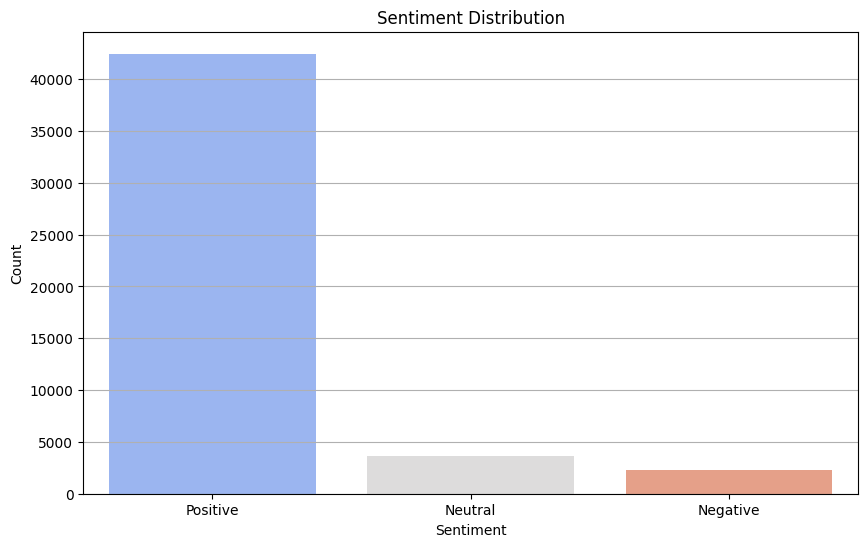

C:\Users\Admin\AppData\Local\Temp\ipykernel_15044\2364141897.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Positive_Count', y='product_id', data=top_products, palette='viridis')


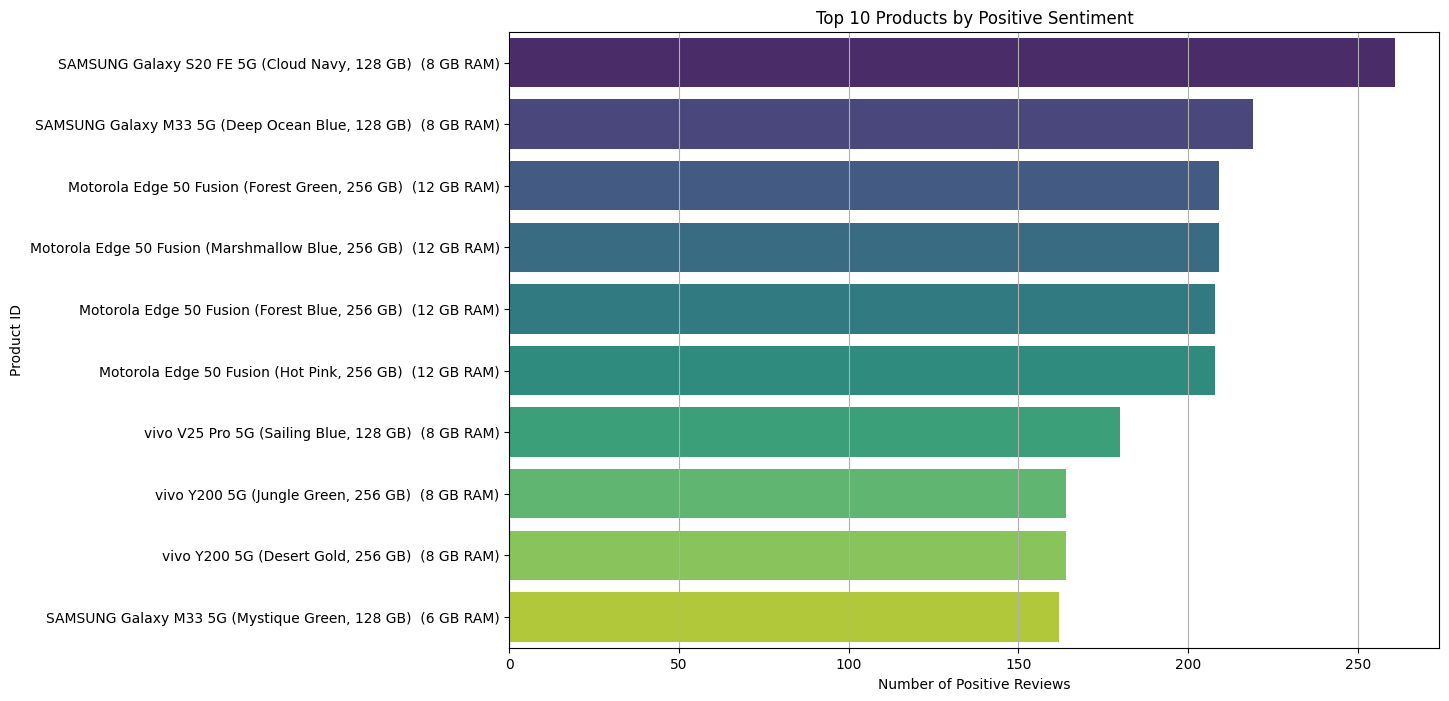

Processed data saved to C:/Users/Admin/Downloads/FlipKart_Processed_Dataset.csv.


In [116]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Download NLTK resources if necessary
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load the dataset
file_path = 'C:/Users/Admin/Downloads/review_data.csv'  # Change the file path if necessary
df = pd.read_csv(file_path)
print(f"Loaded dataset with {df.shape[0]} reviews.")

# Remove the 'Product Link' and rename 'Product Name' to 'product_id'
df.drop(columns=['Product Link'], inplace=True)
df.rename(columns={'Product Name': 'product_id'}, inplace=True)

# Cleaning the Review Text
def clean_review(text):
    """Remove HTML tags, special characters, emojis, and convert to lowercase."""
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters (including emojis)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters, numbers (keep alphabets)
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stopwords)  # Remove stopwords
    return text

# Apply cleaning function to reviews
df['Cleaned_Review'] = df['Review'].apply(clean_review)

# Perform sentiment analysis
def get_sentiment(text):
    """Classify sentiment as positive, negative, or neutral."""
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to the cleaned reviews
df['Sentiment'] = df['Cleaned_Review'].apply(get_sentiment)

# Visualize the sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

# Product Recommendations based on Positive Sentiment
product_sentiment = df.groupby('product_id').agg(Positive_Count=('Sentiment', lambda x: (x == 'Positive').sum())).reset_index()

# Sort products by the highest count of positive reviews
top_products = product_sentiment.sort_values(by='Positive_Count', ascending=False).head(10)

# Plot Top 10 Products by Positive Sentiment
plt.figure(figsize=(12, 8))
sns.barplot(x='Positive_Count', y='product_id', data=top_products, palette='viridis')
plt.title('Top 10 Products by Positive Sentiment')
plt.xlabel('Number of Positive Reviews')
plt.ylabel('Product ID')
plt.grid(axis='x')
plt.show()

# Save the processed data to a CSV file
output_path = 'C:/Users/Admin/Downloads/FlipKart_Processed_Dataset.csv'
df.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}.")


In [117]:
df.head()

,product_id,Price,Rating,Review,Cleaned_Review,Sentiment
0,OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...,36999.0,5,Oppo hai to okk hai 😍😘 Im happy with her 👍 bettr,oppo hai okk hai im happy bettr,Positive
1,OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...,36999.0,5,Good 👍,good,Positive
2,OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...,36999.0,5,Nice product with all features specially its l...,nice product features specially looks camera b...,Positive
3,OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...,36999.0,3,"Product is good, above average. Design is supe...",product good average design superb competing g...,Positive
4,OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...,36999.0,5,This phone is also too good 😊😊😊😊 wonderful 😊 E...,phone also good wonderful everything perfect b...,Positive


In [118]:
# Remove the 'Review' column
df.drop(columns=['Review'], inplace=True)

In [119]:
# final sentinemtal analysis dataset
df.to_csv("sentiment analysis data.csv",index=False)

In [123]:
# final sentinemtal analysis dataset with sentimenal score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already present
nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score and classification
def sentiment_analysis(text):
    sentiment = sia.polarity_scores(text)  # Get sentiment scores
    compound_score = sentiment['compound']  # Use the compound score for overall sentiment
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    return compound_score, sentiment_label

# Apply the sentiment analysis function to the cleaned reviews
df['Sentiment_Score'], df['Sentiment_Label'] = zip(*df['Cleaned_Review'].apply(sentiment_analysis))

# Print the dataset with sentiment score and label
print(df[['product_id', 'Rating', 'Cleaned_Review', 'Sentiment_Score', 'Sentiment_Label']])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                              product_id  Rating  \
0      OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...       5   
1      OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...       5   
2      OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...       5   
3      OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...       3   
4      OPPO Reno 12 Pro 5G (Manish Malhotra Limited E...       5   
...                                                  ...     ...   
48382        Google Pixel 7a (Coral, 128 GB)  (8 GB RAM)       1   
48383        Google Pixel 7a (Coral, 128 GB)  (8 GB RAM)       3   
48384        Google Pixel 7a (Coral, 128 GB)  (8 GB RAM)       3   
48385        Google Pixel 7a (Coral, 128 GB)  (8 GB RAM)       1   
48386        Google Pixel 7a (Coral, 128 GB)  (8 GB RAM)       5   

                                          Cleaned_Review  Sentiment_Score  \
0                        oppo hai okk hai im happy bettr           0.5719   
1                            

In [124]:
df.to_csv("filpcart sentimental score dataset.csv",index=False)